In [59]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [60]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [62]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [63]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [64]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [65]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [67]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


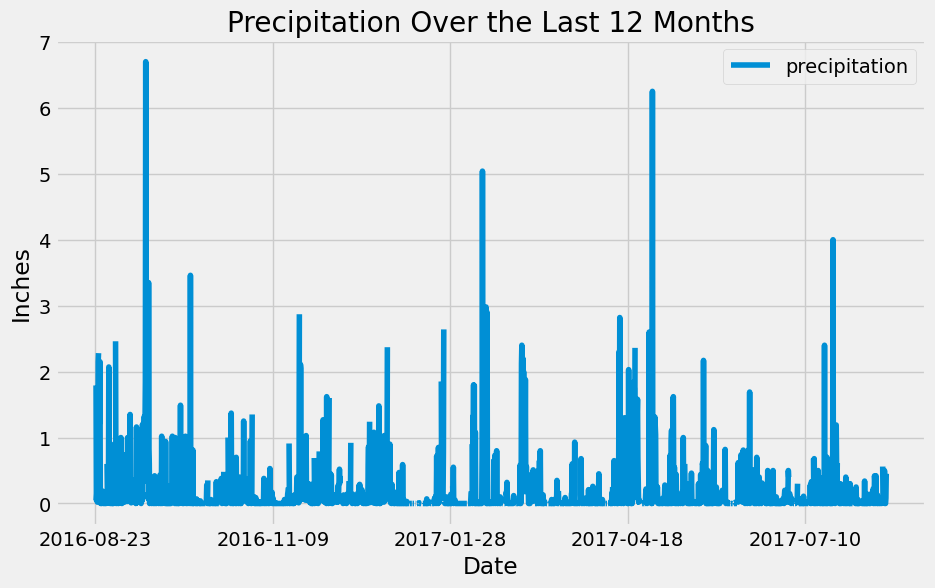

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta

given_date = dt.date(2017, 8, 23)
start_date = given_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months_of_precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_12_months_df = pd.DataFrame(last_12_months_of_precipitation, columns = ['date','prcp'])

# Sort the dataframe by date
last_12_months_df = last_12_months_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
last_12_months_df.plot(x='date', y='prcp', figsize=(10, 6), label='precipitation')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(True)
plt.show()


In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = last_12_months_df['prcp'].describe()
summary_df = pd.DataFrame(summary_statistics)
print(summary_df)

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [70]:
# View Columns in the Station Class
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [71]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).all()
print(total_stations)

[(9,)]


In [72]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = []
for row in session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all():
    
    print(row)



('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [73]:
# Calculate the lowest, highest, and average temperature for the most active station

temperature_stats = session.query(func.min(Measurement.tobs).label('lowest_temperature'),
                                  func.max(Measurement.tobs).label('highest_temperature'),
                                  func.avg(Measurement.tobs).label('average_temperature')).\
    filter(Measurement.station == 'USC00519281').first()

print(temperature_stats)

(54.0, 85.0, 71.66378066378067)


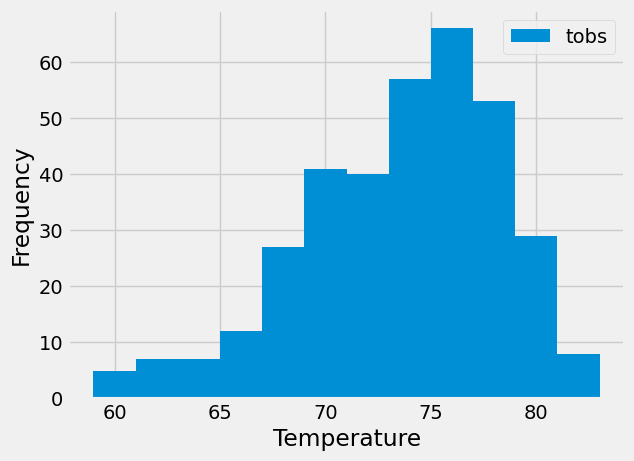

In [74]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

from sqlalchemy import and_

given_date = dt.date(2017, 8, 23)
start_date = given_date - timedelta(days=365)

tobs_last_12_months = session.query(Measurement.date, Measurement.tobs).\
    filter(and_(Measurement.station == 'USC00519281', Measurement.date >= start_date)).all()

# Create a DataFrame from the query results
tobs_last_12_months_df = pd.DataFrame(tobs_last_12_months, columns=['date', 'tobs'])

# Plot the histogram using Pandas plotting
tobs_last_12_months_df.plot.hist(y='tobs', bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [75]:
# Close Session
session.close()